In [2]:
# --Summary Statistics & Missing-Value Report--

import pandas as pd

df = pd.read_csv('../data/togo.csv')

# Summary statistics for all numeric columns
numeric_summary = df.describe()
print("Summary Statistics (numeric columns):\n")
print(numeric_summary)

# Missing values per column
missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df)) * 100

print("\nMissing Values Count per Column:\n")
print(missing_counts)

# Columns with more than 5% missing values
columns_over_5pct_missing = missing_percent[missing_percent > 5]
print("\nColumns with >5% Missing Values:\n")
print(columns_over_5pct_missing)


Summary Statistics (numeric columns):

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.0000

In [3]:
# --Outlier Detection & Basic Cleaning--

import numpy as np
from scipy import stats

# Columns to check for outliers
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Check missing values
missing_counts = df[cols_to_check].isna().sum()
print("Missing values in key columns:\n", missing_counts)

# Compute Z-scores for outlier detection
z_scores = np.abs(stats.zscore(df[cols_to_check], nan_policy='omit'))

# Flag rows with any |Z| > 3
outlier_flags = (z_scores > 3)
df_outliers = df[np.any(outlier_flags, axis=1)]
print(f"Number of rows flagged as outliers: {len(df_outliers)}")

# Optional: inspect first few outlier rows
print(df_outliers.head())

# Handle missing values by imputing median
for col in cols_to_check:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Drop extreme outliers (optional)
df_cleaned = df[~np.any(outlier_flags, axis=1)].copy()

# Export cleaned DataFrame to CSV
df_cleaned.to_csv('../data/togo_clean.csv', index=False)

print("Cleaning completed. Cleaned CSV saved to 'data/togo_clean.csv'")


Missing values in key columns:
 GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Number of rows flagged as outliers: 9251
             Timestamp     GHI    DNI    DHI    ModA    ModB  Tamb    RH   WS  \
4985  2021-10-28 11:06  1139.0  805.1  466.1  1172.0  1154.0  29.8  70.8  2.2   
5410  2021-10-28 18:11    -1.2    0.0    0.0     0.0     0.0  29.7  63.5  6.6   
5411  2021-10-28 18:12    -1.0    0.0    0.0     0.0     0.0  29.3  62.4  6.9   
5413  2021-10-28 18:14    -0.8    0.0    0.0     0.0     0.0  28.6  63.7  7.1   
5420  2021-10-28 18:21    -1.3    0.0    0.0     0.0     0.0  27.7  64.5  6.1   

      WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  \
4985     2.6      0.4  298.6     13.4  977         0            0.0   44.7   
5410     9.7      1.6  122.1     14.3  976         0            0.0   30.0   
5411     8.9      1.2  128.7     10.8  976         0            0.0   29.9   
5413     8.9      1.1  127.9   

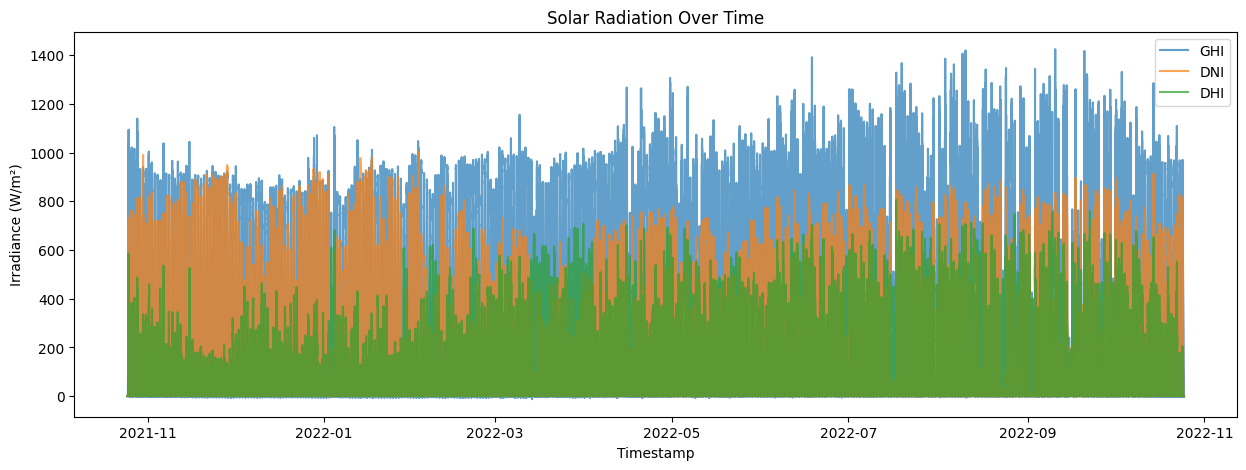

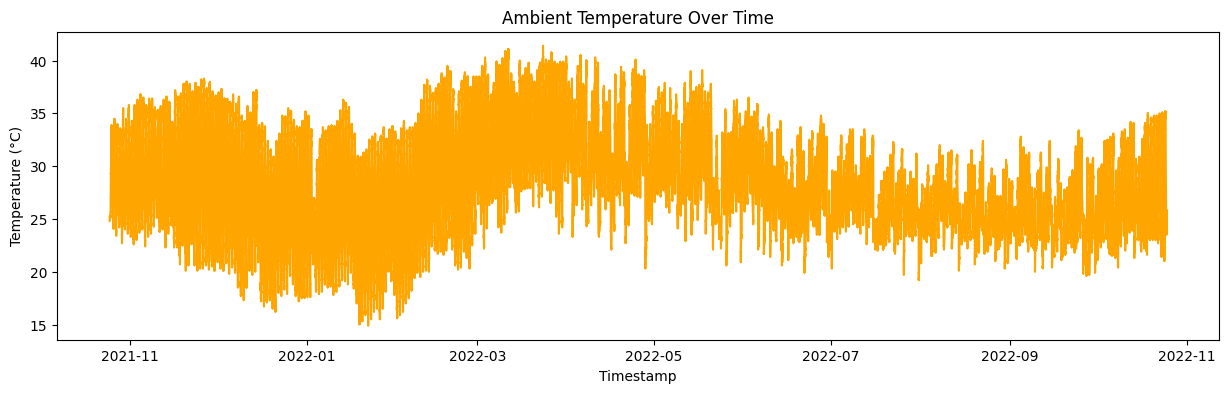

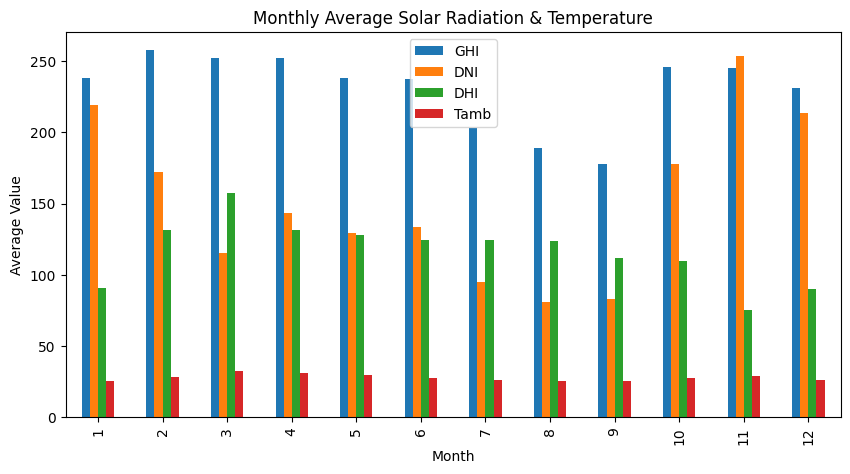

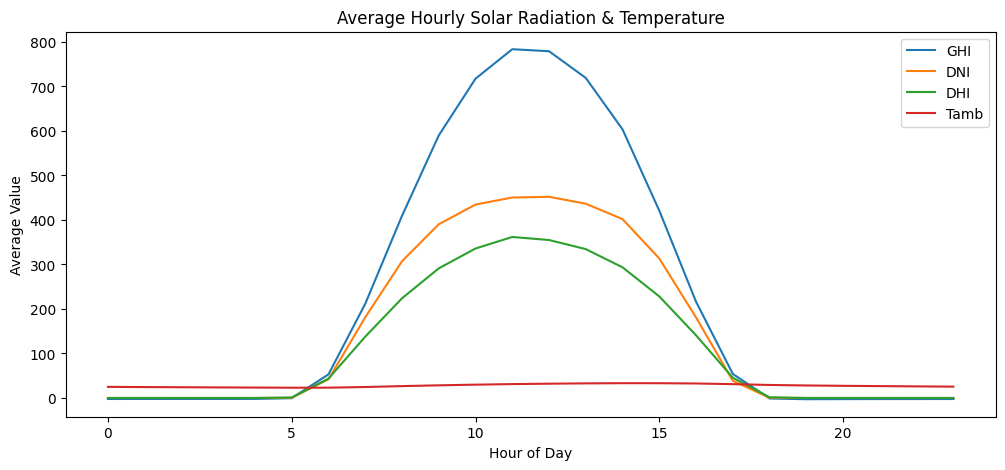

In [4]:
# -- Time Series Analysis --
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])  # drop rows with invalid timestamps

# Line plot: GHI, DNI, DHI over time
plt.figure(figsize=(15,5))
plt.plot(df['Timestamp'], df['GHI'], label='GHI', alpha=0.7)
plt.plot(df['Timestamp'], df['DNI'], label='DNI', alpha=0.7)
plt.plot(df['Timestamp'], df['DHI'], label='DHI', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/m²)')
plt.title('Solar Radiation Over Time')
plt.legend()
plt.show()

# Line plot: Ambient Temperature (Tamb) over time
plt.figure(figsize=(15,4))
plt.plot(df['Timestamp'], df['Tamb'], color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Ambient Temperature Over Time')
plt.show()

# Monthly patterns
df['Month'] = df['Timestamp'].dt.month
monthly_avg = df.groupby('Month')[['GHI','DNI','DHI','Tamb']].mean()
monthly_avg.plot(kind='bar', figsize=(10,5))
plt.ylabel('Average Value')
plt.title('Monthly Average Solar Radiation & Temperature')
plt.show()

# Daily/hourly patterns
df['Hour'] = df['Timestamp'].dt.hour
hourly_avg = df.groupby('Hour')[['GHI','DNI','DHI','Tamb']].mean()
hourly_avg.plot(figsize=(12,5))
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.title('Average Hourly Solar Radiation & Temperature')
plt.show()


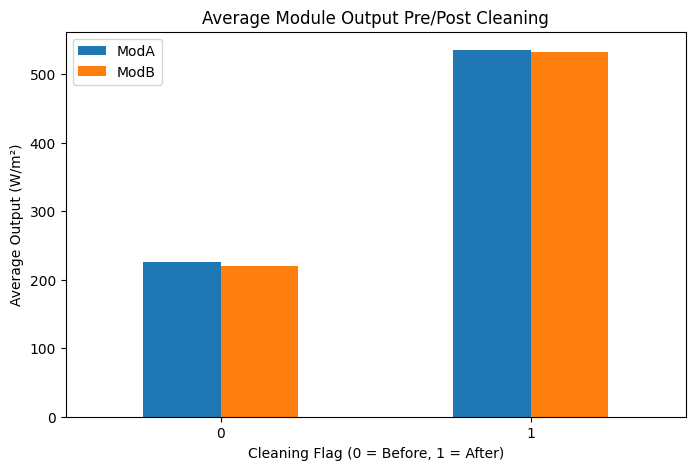

                ModA        ModB
Cleaning                        
0         225.979064  219.401351
1         535.186477  532.211744


In [5]:
# -- Cleaning Impact --
import matplotlib.pyplot as plt

# Ensure 'Cleaning' column is numeric
df['Cleaning'] = df['Cleaning'].astype(int)

# Group by Cleaning flag and calculate average ModA & ModB
cleaning_avg = df.groupby('Cleaning')[['ModA','ModB']].mean()

# Plot the results as a bar chart
cleaning_avg.plot(kind='bar', figsize=(8,5))
plt.title('Average Module Output Pre/Post Cleaning')
plt.xlabel('Cleaning Flag (0 = Before, 1 = After)')
plt.ylabel('Average Output (W/m²)')
plt.xticks(rotation=0)
plt.show()

# Optional: print values to see exact averages
print(cleaning_avg)


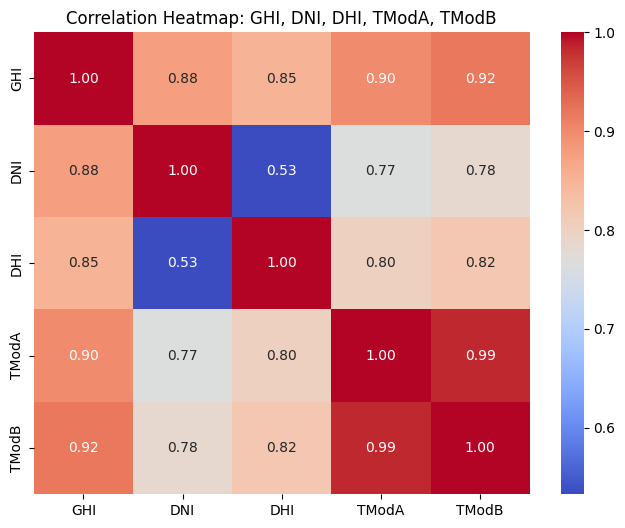

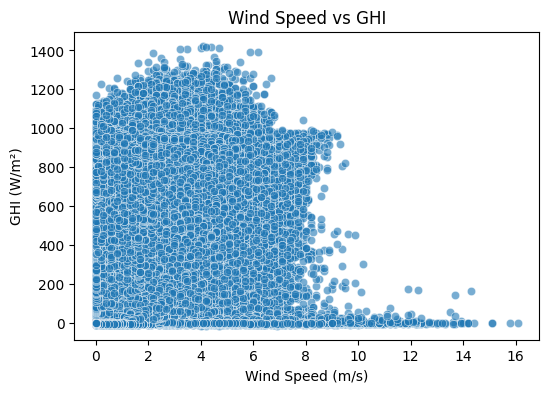

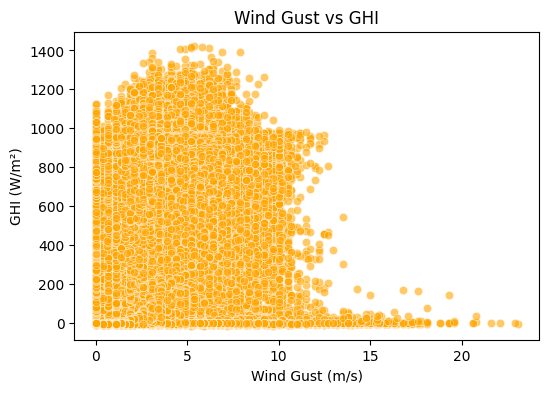

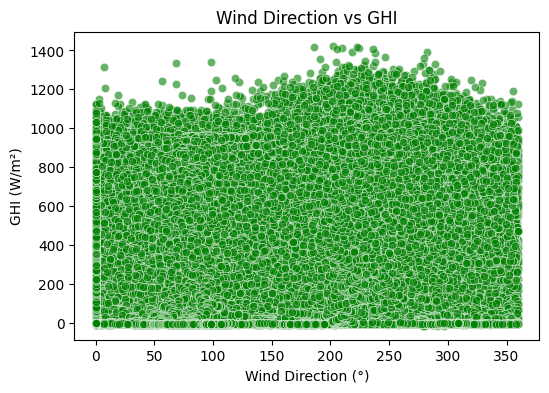

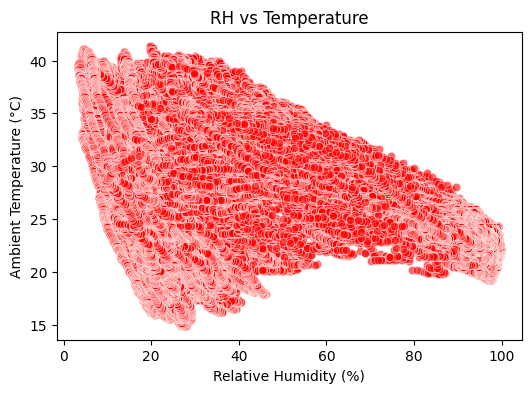

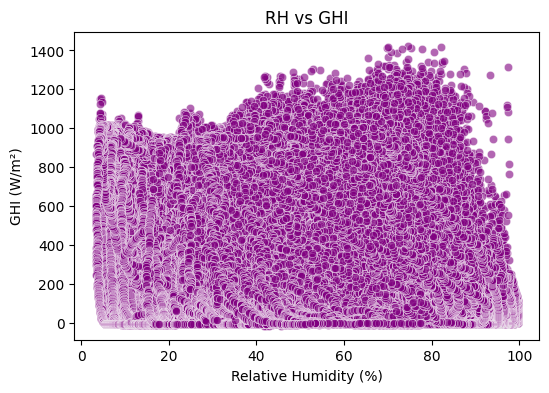

In [6]:
# -- Correlation & Relationship Analysis --
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Heatmap for selected columns
cols_corr = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[cols_corr].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: GHI, DNI, DHI, TModA, TModB')
plt.show()

# Scatter Plots

# WS vs GHI
plt.figure(figsize=(6,4))
sns.scatterplot(x='WS', y='GHI', data=df, alpha=0.6)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Speed vs GHI')
plt.show()

# WSgust vs GHI
plt.figure(figsize=(6,4))
sns.scatterplot(x='WSgust', y='GHI', data=df, alpha=0.6, color='orange')
plt.xlabel('Wind Gust (m/s)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Gust vs GHI')
plt.show()

# WD (Wind Direction) vs GHI
plt.figure(figsize=(6,4))
sns.scatterplot(x='WD', y='GHI', data=df, alpha=0.6, color='green')
plt.xlabel('Wind Direction (°)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Direction vs GHI')
plt.show()

# RH vs Tamb
plt.figure(figsize=(6,4))
sns.scatterplot(x='RH', y='Tamb', data=df, alpha=0.6, color='red')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('RH vs Temperature')
plt.show()

# RH vs GHI
plt.figure(figsize=(6,4))
sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.6, color='purple')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.title('RH vs GHI')
plt.show()


In [ ]:
# -- Wind & Distribution Analysis --
import matplotlib.pyplot as plt
import numpy as np

# Drop rows with missing wind values
wind_df = df[['WD', 'WS']].dropna()

# Optional: sample for faster plotting if dataset is large
if len(wind_df) > 2000:
    wind_df = wind_df.sample(2000, random_state=42)

# Convert degrees to radians for polar plotting
theta = np.deg2rad(wind_df['WD'])
r = wind_df['WS']

# Quick scatter-based wind rose
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.scatter(theta, r, alpha=0.5, s=10)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.title("Wind Rose (Scatter Style)")
plt.show()

# Histograms for GHI and WS
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df['GHI'].dropna(), bins=30)
plt.title('Distribution of GHI')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(df['WS'].dropna(), bins=30)
plt.title('Distribution of Wind Speed (WS)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


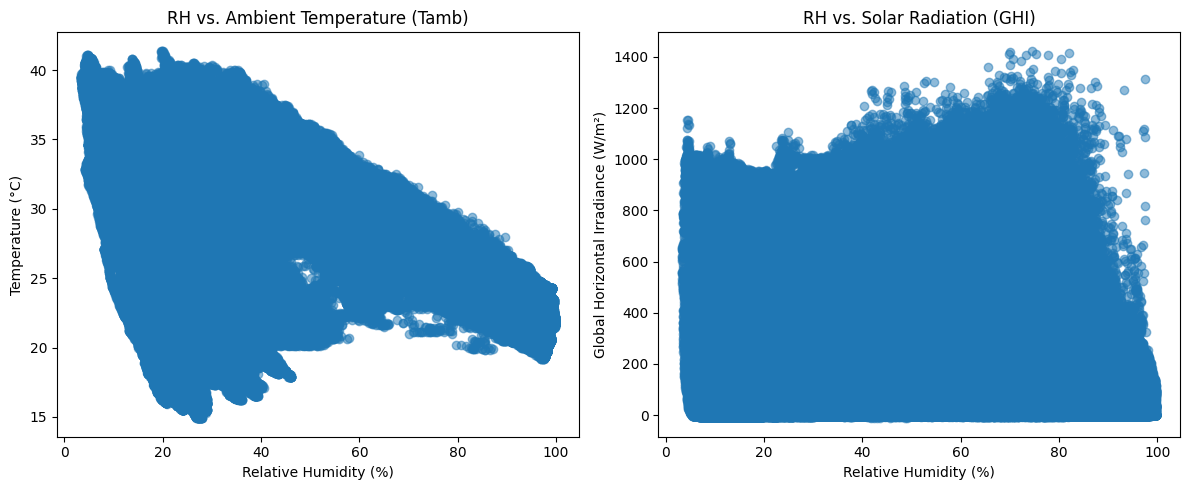

In [7]:
# -- Temperature Analysis --
import matplotlib.pyplot as plt

# Drop rows with missing relevant values
temp_df = df[['RH', 'Tamb', 'GHI']].dropna()

# Scatter plot: RH vs Tamb
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(temp_df['RH'], temp_df['Tamb'], alpha=0.5)
plt.title('RH vs. Ambient Temperature (Tamb)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Temperature (°C)')

# Scatter plot: RH vs GHI
plt.subplot(1,2,2)
plt.scatter(temp_df['RH'], temp_df['GHI'], alpha=0.5)
plt.title('RH vs. Solar Radiation (GHI)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Global Horizontal Irradiance (W/m²)')

plt.tight_layout()
plt.show()


/tmp/ipykernel_24903/1243152651.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


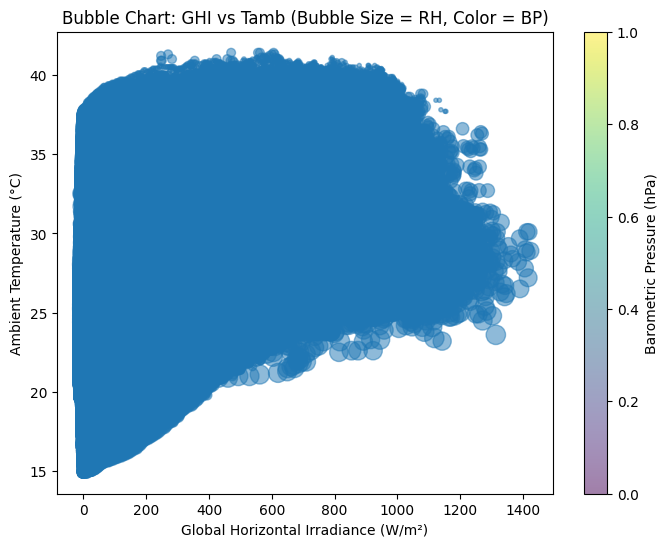

In [8]:
# -- Bubble Chart --
import matplotlib.pyplot as plt

# Drop missing values for the relevant columns
bubble_df = df[['GHI', 'Tamb', 'RH', 'BP']].dropna()

# Bubble Chart: GHI vs Tamb with bubble size = RH
plt.figure(figsize=(8,6))
plt.scatter(
    bubble_df['GHI'], 
    bubble_df['Tamb'], 
    s=bubble_df['RH'] * 2,   # Scale bubble size
    alpha=0.5, 
    cmap='viridis'
)
plt.title('Bubble Chart: GHI vs Tamb (Bubble Size = RH, Color = BP)')
plt.xlabel('Global Horizontal Irradiance (W/m²)')
plt.ylabel('Ambient Temperature (°C)')
plt.colorbar(label='Barometric Pressure (hPa)')
plt.show()
